# RNN手动实现

实现RNN预测股价，主要分为以下几个部分：  
1、数据集载入   
2、RNN类实现  
3、训练函数实现  

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import torch
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt
import random

利用akshare数据库导入股票数据

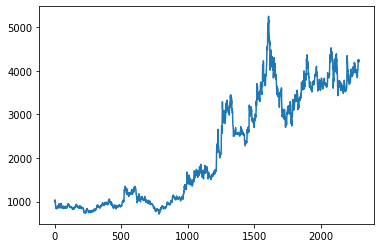

In [2]:
import akshare as ak
data = ak.stock_zh_a_daily(symbol="sz000002", start_date="20101103", end_date="20201116", adjust="hfq")
plt.plot(data.open)

In [29]:
# 考虑加入换手率、成交量、涨跌幅等因素
std = data.std()
mean = data.mean()
data["open"] = (data.open - mean.open) / std.open
data["volume"] = (data.volume - mean.volume) / std.volume
data["turnover"] = (data.turnover - mean.turnover) / std.turnover
data = data.loc[:, ["open", "volume", "turnover"]]
data.head()

,open,volume,turnover
0,-0.934818,0.609411,0.616826
1,-0.918352,0.163150,0.168099
2,-0.908468,0.438174,0.444643
3,-0.919995,0.791633,0.800056
4,-0.914235,1.070053,1.080014


载入数据集和数据迭代器

In [30]:
def random_data_iter(seq, batch_size, seq_len):
    # 首先要确定起始位置
    seq = seq[random.randint(0, seq_len):]
    # 其次确定序列总数
    num_seq = (len(seq)-1) // seq_len
    # 找到所有子序列起始位置
    init_indexs = list(range(0, num_seq*seq_len, seq_len))
    # 打乱
    random.shuffle(init_indexs)
    
    def _data(index):
        return seq[index:index+seq_len]
    
    # 计算batch数量
    num_batches = num_seq // batch_size
    for i in range(0, num_batches*batch_size, batch_size):
        indice = init_indexs[i:i+batch_size]
        X = [_data(j) for j in indice]
        Y = [_data(j+1) for j in indice]
        yield torch.tensor(X).reshape((batch_size,seq_len,3)), torch.tensor(Y).reshape((batch_size,seq_len,3))

In [31]:
# 建立数据迭代类，来满足不同epoch的训练
class SeqIter:
    def __init__(self, seq, batch_size, seq_len):
        self.seq = seq.values
        self.batch_size = batch_size
        self.seq_len = seq_len
    
    def __iter__(self):
        return random_data_iter(self.seq, self.batch_size, self.seq_len)

RNN类实现

In [32]:
def get_param(input_dim, output_dim, hidden_dim, device):
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    # 分别创建 W_hx, W_hh, b_h, W_hq, h_q
    W_hx = normal((input_dim ,hidden_dim))
    W_hh = normal((hidden_dim, hidden_dim))
    b_h = torch.zeros(hidden_dim, device=device)
    W_hq = normal((hidden_dim, output_dim))
    b_q = torch.zeros(output_dim, device=device)
    
    params = [W_hx, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
        
    return params
        

In [33]:
def rnn(X, params, state):
    # 获取参数
    W_hx, W_hh, b_h, W_hq, b_q = params
    H, = state
    
    #更改X的w维度
    X = X.permute(1, 0, 2)
    
    outputs = []
    # 计算并返回
    for x in X:
        H = torch.matmul(x, W_hx) + torch.matmul(H, W_hh) + b_h
        o = (torch.matmul(H, W_hq) + b_q)
        outputs.append(o.reshape((-1, o.shape[0], 3)))
    return torch.cat(outputs, dim=0).permute(1, 0, 2).squeeze(2), (H, )

In [34]:
def init_state(batch_size, hidden_dim):
    return torch.zeros((batch_size, hidden_dim))

In [35]:
class MyRNN:
    def __init__(self, input_dim, output_dim, batch_size, hidden_dim, init_state, forward_fn, get_param, device=torch.device('cpu')):
        #传入相关参数：input_dim, batch_size, hidden_dim, init_state, forward_fn, 
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.init_state = init_state
        self.forward_fn = forward_fn
        self.device = device
        #创建权重
        self.params = get_param(input_dim, output_dim, hidden_dim, device)
    
    def __call__(self, X, state):
        return self.forward_fn(X, self.params, state)
    
    def begin_state(self):
        return (init_state(self.batch_size, self.hidden_dim), )

测试一下输入输出

In [36]:
net = MyRNN(3, 3, 64, 10, init_state, rnn, get_param)
state = net.begin_state()
for X, Y in SeqIter(data, 64, 20):
    state = net.begin_state()
    y_hat, state = net(X.float(), state)
    print(Y.reshape(-1).float())
    break

tensor([ 0.3258, -0.6822, -0.6835,  ...,  1.5215, -0.4471, -0.4487])


训练函数实现

In [37]:
def grad_clipping(net, theta):
    params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [38]:
def train_epoch(net, train_iter, loss, updater, device):
    total_loss = 0
    for X, Y in train_iter(data, 64, 5):
        # 初始化
        state = net.begin_state()
        y_real = Y.reshape(-1).float()
        X, y_real = X.float(), y_real.float()
        
        y_hat, state = net(X, state)
        y_hat = y_hat.reshape(-1).float()
        l = loss(y_real, y_hat).mean()
        print(l)
        l.backward()
        grad_clipping(net, 1)
        updater(1)
        total_loss += l
    return total_loss

In [39]:
def backward_fn(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param[:] = param - lr * param.grad / batch_size
            param.grad.zero_()

In [40]:
def train(net, train_iter, epoches, lr,  device=torch.device('cpu')):
    loss = torch.nn.MSELoss()
    updater = lambda batch_size: backward_fn(net.params, lr, batch_size)
    
    for epoch in range(epoches):
        total_loss = train_epoch(net, train_iter, loss, updater, device)
        if (epoch + 1) % 10 == 0:
            print(f'第{epoch+1}次训练，损失：{total_loss}')

In [41]:
net = MyRNN(3, 3, 64, 100, init_state, rnn, get_param)
train(net, SeqIter, 1000, 0.03)

tensor(1.0120, grad_fn=<MeanBackward0>)
tensor(1.1398, grad_fn=<MeanBackward0>)
tensor(0.6879, grad_fn=<MeanBackward0>)
tensor(1.0020, grad_fn=<MeanBackward0>)
tensor(0.9311, grad_fn=<MeanBackward0>)
tensor(1.0695, grad_fn=<MeanBackward0>)
tensor(0.8230, grad_fn=<MeanBackward0>)
tensor(0.7017, grad_fn=<MeanBackward0>)
tensor(0.6745, grad_fn=<MeanBackward0>)
tensor(1.3937, grad_fn=<MeanBackward0>)
tensor(0.7532, grad_fn=<MeanBackward0>)
tensor(0.9536, grad_fn=<MeanBackward0>)
tensor(1.3007, grad_fn=<MeanBackward0>)
tensor(1.2220, grad_fn=<MeanBackward0>)
tensor(0.9348, grad_fn=<MeanBackward0>)
tensor(0.9308, grad_fn=<MeanBackward0>)
tensor(0.8194, grad_fn=<MeanBackward0>)
tensor(1.5095, grad_fn=<MeanBackward0>)
tensor(1.0529, grad_fn=<MeanBackward0>)
tensor(0.6551, grad_fn=<MeanBackward0>)
tensor(0.8328, grad_fn=<MeanBackward0>)
tensor(1.0315, grad_fn=<MeanBackward0>)
tensor(1.0421, grad_fn=<MeanBackward0>)
tensor(1.2671, grad_fn=<MeanBackward0>)
tensor(0.8019, grad_fn=<MeanBackward0>)


tensor(0.0892, grad_fn=<MeanBackward0>)
tensor(0.1234, grad_fn=<MeanBackward0>)
tensor(0.2811, grad_fn=<MeanBackward0>)
tensor(0.1882, grad_fn=<MeanBackward0>)
tensor(0.1208, grad_fn=<MeanBackward0>)
tensor(0.2150, grad_fn=<MeanBackward0>)
tensor(0.2634, grad_fn=<MeanBackward0>)
tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.1563, grad_fn=<MeanBackward0>)
tensor(0.2856, grad_fn=<MeanBackward0>)
tensor(0.1901, grad_fn=<MeanBackward0>)
tensor(0.1269, grad_fn=<MeanBackward0>)
tensor(0.2174, grad_fn=<MeanBackward0>)
tensor(0.1886, grad_fn=<MeanBackward0>)
tensor(0.4533, grad_fn=<MeanBackward0>)
tensor(0.1743, grad_fn=<MeanBackward0>)
tensor(0.2240, grad_fn=<MeanBackward0>)
tensor(0.1272, grad_fn=<MeanBackward0>)
tensor(0.2109, grad_fn=<MeanBackward0>)
tensor(0.1983, grad_fn=<MeanBackward0>)
tensor(0.3781, grad_fn=<MeanBackward0>)
tensor(0.3187, grad_fn=<MeanBackward0>)
tensor(0.2355, grad_fn=<MeanBackward0>)
tensor(0.5049, grad_fn=<MeanBackward0>)
tensor(0.1363, grad_fn=<MeanBackward0>)


tensor(0.0815, grad_fn=<MeanBackward0>)
tensor(0.1813, grad_fn=<MeanBackward0>)
tensor(0.3118, grad_fn=<MeanBackward0>)
tensor(0.2241, grad_fn=<MeanBackward0>)
tensor(0.1731, grad_fn=<MeanBackward0>)
tensor(0.1498, grad_fn=<MeanBackward0>)
tensor(0.2134, grad_fn=<MeanBackward0>)
tensor(0.1247, grad_fn=<MeanBackward0>)
tensor(0.0849, grad_fn=<MeanBackward0>)
tensor(0.5591, grad_fn=<MeanBackward0>)
tensor(0.2001, grad_fn=<MeanBackward0>)
tensor(0.1607, grad_fn=<MeanBackward0>)
tensor(0.3183, grad_fn=<MeanBackward0>)
tensor(0.1986, grad_fn=<MeanBackward0>)
tensor(0.2881, grad_fn=<MeanBackward0>)
tensor(0.1569, grad_fn=<MeanBackward0>)
tensor(0.1625, grad_fn=<MeanBackward0>)
tensor(0.4364, grad_fn=<MeanBackward0>)
tensor(0.2861, grad_fn=<MeanBackward0>)
tensor(0.1063, grad_fn=<MeanBackward0>)
tensor(0.1762, grad_fn=<MeanBackward0>)
tensor(0.2395, grad_fn=<MeanBackward0>)
tensor(0.2393, grad_fn=<MeanBackward0>)
tensor(0.3883, grad_fn=<MeanBackward0>)
tensor(0.1519, grad_fn=<MeanBackward0>)


tensor(0.2772, grad_fn=<MeanBackward0>)
tensor(0.3350, grad_fn=<MeanBackward0>)
tensor(0.1664, grad_fn=<MeanBackward0>)
tensor(0.2523, grad_fn=<MeanBackward0>)
tensor(0.1879, grad_fn=<MeanBackward0>)
tensor(0.1831, grad_fn=<MeanBackward0>)
tensor(0.2172, grad_fn=<MeanBackward0>)
tensor(0.2270, grad_fn=<MeanBackward0>)
tensor(0.3863, grad_fn=<MeanBackward0>)
tensor(0.2445, grad_fn=<MeanBackward0>)
tensor(0.1992, grad_fn=<MeanBackward0>)
tensor(0.1198, grad_fn=<MeanBackward0>)
tensor(0.2271, grad_fn=<MeanBackward0>)
tensor(0.2299, grad_fn=<MeanBackward0>)
tensor(0.0776, grad_fn=<MeanBackward0>)
tensor(0.3224, grad_fn=<MeanBackward0>)
tensor(0.5030, grad_fn=<MeanBackward0>)
tensor(0.1665, grad_fn=<MeanBackward0>)
第100次训练，损失：1.6462604999542236
tensor(0.1203, grad_fn=<MeanBackward0>)
tensor(0.3743, grad_fn=<MeanBackward0>)
tensor(0.1961, grad_fn=<MeanBackward0>)
tensor(0.1695, grad_fn=<MeanBackward0>)
tensor(0.2181, grad_fn=<MeanBackward0>)
tensor(0.1988, grad_fn=<MeanBackward0>)
tensor(0.3

tensor(0.1703, grad_fn=<MeanBackward0>)
tensor(0.2079, grad_fn=<MeanBackward0>)
tensor(0.1891, grad_fn=<MeanBackward0>)
tensor(0.2030, grad_fn=<MeanBackward0>)
tensor(0.1578, grad_fn=<MeanBackward0>)
tensor(0.4079, grad_fn=<MeanBackward0>)
tensor(0.2185, grad_fn=<MeanBackward0>)
tensor(0.1952, grad_fn=<MeanBackward0>)
tensor(0.0884, grad_fn=<MeanBackward0>)
tensor(0.3063, grad_fn=<MeanBackward0>)
tensor(0.1188, grad_fn=<MeanBackward0>)
tensor(0.4267, grad_fn=<MeanBackward0>)
tensor(0.1930, grad_fn=<MeanBackward0>)
tensor(0.2583, grad_fn=<MeanBackward0>)
tensor(0.4762, grad_fn=<MeanBackward0>)
tensor(0.2995, grad_fn=<MeanBackward0>)
tensor(0.2453, grad_fn=<MeanBackward0>)
tensor(0.1497, grad_fn=<MeanBackward0>)
tensor(0.1720, grad_fn=<MeanBackward0>)
tensor(0.0750, grad_fn=<MeanBackward0>)
tensor(0.2017, grad_fn=<MeanBackward0>)
tensor(0.0993, grad_fn=<MeanBackward0>)
tensor(0.1541, grad_fn=<MeanBackward0>)
tensor(0.6118, grad_fn=<MeanBackward0>)
tensor(0.1314, grad_fn=<MeanBackward0>)


tensor(0.2548, grad_fn=<MeanBackward0>)
tensor(0.1384, grad_fn=<MeanBackward0>)
tensor(0.2506, grad_fn=<MeanBackward0>)
tensor(0.2972, grad_fn=<MeanBackward0>)
tensor(0.1215, grad_fn=<MeanBackward0>)
tensor(0.1475, grad_fn=<MeanBackward0>)
tensor(0.3537, grad_fn=<MeanBackward0>)
tensor(0.2440, grad_fn=<MeanBackward0>)
tensor(0.0918, grad_fn=<MeanBackward0>)
tensor(0.2203, grad_fn=<MeanBackward0>)
tensor(0.4419, grad_fn=<MeanBackward0>)
tensor(0.1752, grad_fn=<MeanBackward0>)
tensor(0.1938, grad_fn=<MeanBackward0>)
tensor(0.2634, grad_fn=<MeanBackward0>)
tensor(0.1258, grad_fn=<MeanBackward0>)
tensor(0.1292, grad_fn=<MeanBackward0>)
tensor(0.6615, grad_fn=<MeanBackward0>)
tensor(0.1214, grad_fn=<MeanBackward0>)
tensor(0.2109, grad_fn=<MeanBackward0>)
tensor(0.1396, grad_fn=<MeanBackward0>)
tensor(0.1270, grad_fn=<MeanBackward0>)
tensor(0.2341, grad_fn=<MeanBackward0>)
tensor(0.1106, grad_fn=<MeanBackward0>)
tensor(0.2490, grad_fn=<MeanBackward0>)
tensor(0.1852, grad_fn=<MeanBackward0>)


tensor(0.4058, grad_fn=<MeanBackward0>)
tensor(0.1754, grad_fn=<MeanBackward0>)
tensor(0.2123, grad_fn=<MeanBackward0>)
tensor(0.1498, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.1301, grad_fn=<MeanBackward0>)
tensor(0.4300, grad_fn=<MeanBackward0>)
tensor(0.2699, grad_fn=<MeanBackward0>)
tensor(0.1380, grad_fn=<MeanBackward0>)
tensor(0.2593, grad_fn=<MeanBackward0>)
tensor(0.1939, grad_fn=<MeanBackward0>)
tensor(0.1072, grad_fn=<MeanBackward0>)
tensor(0.1393, grad_fn=<MeanBackward0>)
tensor(0.1772, grad_fn=<MeanBackward0>)
tensor(0.3496, grad_fn=<MeanBackward0>)
tensor(0.3707, grad_fn=<MeanBackward0>)
tensor(0.2746, grad_fn=<MeanBackward0>)
tensor(0.1198, grad_fn=<MeanBackward0>)
tensor(0.2128, grad_fn=<MeanBackward0>)
tensor(0.2491, grad_fn=<MeanBackward0>)
tensor(0.6826, grad_fn=<MeanBackward0>)
tensor(0.0784, grad_fn=<MeanBackward0>)
tensor(0.1583, grad_fn=<MeanBackward0>)
tensor(0.1087, grad_fn=<MeanBackward0>)
tensor(0.2768, grad_fn=<MeanBackward0>)


tensor(0.1172, grad_fn=<MeanBackward0>)
tensor(0.2115, grad_fn=<MeanBackward0>)
tensor(0.1319, grad_fn=<MeanBackward0>)
tensor(0.4957, grad_fn=<MeanBackward0>)
tensor(0.2687, grad_fn=<MeanBackward0>)
tensor(0.2886, grad_fn=<MeanBackward0>)
tensor(0.4306, grad_fn=<MeanBackward0>)
tensor(0.1631, grad_fn=<MeanBackward0>)
tensor(0.1149, grad_fn=<MeanBackward0>)
tensor(0.1885, grad_fn=<MeanBackward0>)
tensor(0.2291, grad_fn=<MeanBackward0>)
tensor(0.1955, grad_fn=<MeanBackward0>)
tensor(0.2016, grad_fn=<MeanBackward0>)
tensor(0.2384, grad_fn=<MeanBackward0>)
tensor(0.1763, grad_fn=<MeanBackward0>)
tensor(0.1571, grad_fn=<MeanBackward0>)
tensor(0.1934, grad_fn=<MeanBackward0>)
tensor(0.2305, grad_fn=<MeanBackward0>)
tensor(0.3223, grad_fn=<MeanBackward0>)
tensor(0.2649, grad_fn=<MeanBackward0>)
tensor(0.3218, grad_fn=<MeanBackward0>)
tensor(0.1867, grad_fn=<MeanBackward0>)
tensor(0.2268, grad_fn=<MeanBackward0>)
tensor(0.1129, grad_fn=<MeanBackward0>)
tensor(0.1210, grad_fn=<MeanBackward0>)


tensor(0.0991, grad_fn=<MeanBackward0>)
tensor(0.1867, grad_fn=<MeanBackward0>)
tensor(0.2005, grad_fn=<MeanBackward0>)
tensor(0.3587, grad_fn=<MeanBackward0>)
tensor(0.1503, grad_fn=<MeanBackward0>)
tensor(0.1385, grad_fn=<MeanBackward0>)
tensor(0.0947, grad_fn=<MeanBackward0>)
tensor(0.2838, grad_fn=<MeanBackward0>)
tensor(0.3515, grad_fn=<MeanBackward0>)
第280次训练，损失：1.5779780149459839
tensor(0.3025, grad_fn=<MeanBackward0>)
tensor(0.4506, grad_fn=<MeanBackward0>)
tensor(0.1340, grad_fn=<MeanBackward0>)
tensor(0.1586, grad_fn=<MeanBackward0>)
tensor(0.1320, grad_fn=<MeanBackward0>)
tensor(0.2105, grad_fn=<MeanBackward0>)
tensor(0.2546, grad_fn=<MeanBackward0>)
tensor(0.1737, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.1311, grad_fn=<MeanBackward0>)
tensor(0.1886, grad_fn=<MeanBackward0>)
tensor(0.2429, grad_fn=<MeanBackward0>)
tensor(0.6056, grad_fn=<MeanBackward0>)
tensor(0.1363, grad_fn=<MeanBackward0>)
tensor(0.2067, grad_fn=<MeanBackward0>)
tensor(0.1

tensor(0.1975, grad_fn=<MeanBackward0>)
tensor(0.3460, grad_fn=<MeanBackward0>)
tensor(0.2286, grad_fn=<MeanBackward0>)
tensor(0.3738, grad_fn=<MeanBackward0>)
tensor(0.1527, grad_fn=<MeanBackward0>)
tensor(0.3739, grad_fn=<MeanBackward0>)
tensor(0.1891, grad_fn=<MeanBackward0>)
tensor(0.1226, grad_fn=<MeanBackward0>)
tensor(0.3075, grad_fn=<MeanBackward0>)
tensor(0.2279, grad_fn=<MeanBackward0>)
tensor(0.2070, grad_fn=<MeanBackward0>)
tensor(0.2007, grad_fn=<MeanBackward0>)
tensor(0.3456, grad_fn=<MeanBackward0>)
tensor(0.1377, grad_fn=<MeanBackward0>)
tensor(0.2776, grad_fn=<MeanBackward0>)
tensor(0.2298, grad_fn=<MeanBackward0>)
tensor(0.2147, grad_fn=<MeanBackward0>)
tensor(0.2055, grad_fn=<MeanBackward0>)
tensor(0.2579, grad_fn=<MeanBackward0>)
tensor(0.2014, grad_fn=<MeanBackward0>)
tensor(0.1595, grad_fn=<MeanBackward0>)
tensor(0.2739, grad_fn=<MeanBackward0>)
tensor(0.3310, grad_fn=<MeanBackward0>)
tensor(0.1197, grad_fn=<MeanBackward0>)
tensor(0.2492, grad_fn=<MeanBackward0>)


tensor(0.2111, grad_fn=<MeanBackward0>)
tensor(0.2110, grad_fn=<MeanBackward0>)
tensor(0.2223, grad_fn=<MeanBackward0>)
tensor(0.2164, grad_fn=<MeanBackward0>)
tensor(0.1908, grad_fn=<MeanBackward0>)
tensor(0.1649, grad_fn=<MeanBackward0>)
tensor(0.1861, grad_fn=<MeanBackward0>)
tensor(0.4453, grad_fn=<MeanBackward0>)
tensor(0.2011, grad_fn=<MeanBackward0>)
tensor(0.1323, grad_fn=<MeanBackward0>)
tensor(0.3178, grad_fn=<MeanBackward0>)
tensor(0.4710, grad_fn=<MeanBackward0>)
tensor(0.1821, grad_fn=<MeanBackward0>)
tensor(0.2312, grad_fn=<MeanBackward0>)
tensor(0.0964, grad_fn=<MeanBackward0>)
tensor(0.1354, grad_fn=<MeanBackward0>)
tensor(0.4102, grad_fn=<MeanBackward0>)
tensor(0.2516, grad_fn=<MeanBackward0>)
tensor(0.2055, grad_fn=<MeanBackward0>)
tensor(0.1266, grad_fn=<MeanBackward0>)
tensor(0.2444, grad_fn=<MeanBackward0>)
tensor(0.2339, grad_fn=<MeanBackward0>)
第350次训练，损失：1.6076797246932983
tensor(0.1632, grad_fn=<MeanBackward0>)
tensor(0.2797, grad_fn=<MeanBackward0>)
tensor(0.4

tensor(0.2443, grad_fn=<MeanBackward0>)
tensor(0.1525, grad_fn=<MeanBackward0>)
tensor(0.1136, grad_fn=<MeanBackward0>)
tensor(0.2188, grad_fn=<MeanBackward0>)
tensor(0.2474, grad_fn=<MeanBackward0>)
tensor(0.2791, grad_fn=<MeanBackward0>)
tensor(0.1248, grad_fn=<MeanBackward0>)
tensor(0.1924, grad_fn=<MeanBackward0>)
tensor(0.2215, grad_fn=<MeanBackward0>)
tensor(0.2492, grad_fn=<MeanBackward0>)
tensor(0.2337, grad_fn=<MeanBackward0>)
tensor(0.3231, grad_fn=<MeanBackward0>)
tensor(0.1831, grad_fn=<MeanBackward0>)
tensor(0.2768, grad_fn=<MeanBackward0>)
tensor(0.0953, grad_fn=<MeanBackward0>)
tensor(0.1460, grad_fn=<MeanBackward0>)
tensor(0.4948, grad_fn=<MeanBackward0>)
tensor(0.1957, grad_fn=<MeanBackward0>)
tensor(0.1990, grad_fn=<MeanBackward0>)
tensor(0.1548, grad_fn=<MeanBackward0>)
tensor(0.1870, grad_fn=<MeanBackward0>)
tensor(0.2534, grad_fn=<MeanBackward0>)
tensor(0.1695, grad_fn=<MeanBackward0>)
tensor(0.2223, grad_fn=<MeanBackward0>)
tensor(0.1273, grad_fn=<MeanBackward0>)


tensor(0.1631, grad_fn=<MeanBackward0>)
tensor(0.2378, grad_fn=<MeanBackward0>)
tensor(0.0977, grad_fn=<MeanBackward0>)
tensor(0.2057, grad_fn=<MeanBackward0>)
tensor(0.1849, grad_fn=<MeanBackward0>)
tensor(0.4987, grad_fn=<MeanBackward0>)
tensor(0.1521, grad_fn=<MeanBackward0>)
tensor(0.0905, grad_fn=<MeanBackward0>)
tensor(0.2213, grad_fn=<MeanBackward0>)
tensor(0.1052, grad_fn=<MeanBackward0>)
tensor(0.2813, grad_fn=<MeanBackward0>)
tensor(0.2266, grad_fn=<MeanBackward0>)
tensor(0.3675, grad_fn=<MeanBackward0>)
tensor(0.2400, grad_fn=<MeanBackward0>)
tensor(0.2041, grad_fn=<MeanBackward0>)
tensor(0.1370, grad_fn=<MeanBackward0>)
tensor(0.2265, grad_fn=<MeanBackward0>)
tensor(0.2061, grad_fn=<MeanBackward0>)
tensor(0.3870, grad_fn=<MeanBackward0>)
tensor(0.0966, grad_fn=<MeanBackward0>)
tensor(0.3399, grad_fn=<MeanBackward0>)
tensor(0.1002, grad_fn=<MeanBackward0>)
tensor(0.2173, grad_fn=<MeanBackward0>)
tensor(0.2649, grad_fn=<MeanBackward0>)
tensor(0.1927, grad_fn=<MeanBackward0>)


tensor(0.1182, grad_fn=<MeanBackward0>)
tensor(0.2190, grad_fn=<MeanBackward0>)
tensor(0.2079, grad_fn=<MeanBackward0>)
tensor(0.1269, grad_fn=<MeanBackward0>)
tensor(0.1936, grad_fn=<MeanBackward0>)
tensor(0.1348, grad_fn=<MeanBackward0>)
tensor(0.4566, grad_fn=<MeanBackward0>)
tensor(0.2591, grad_fn=<MeanBackward0>)
tensor(0.2780, grad_fn=<MeanBackward0>)
tensor(0.1762, grad_fn=<MeanBackward0>)
tensor(0.3164, grad_fn=<MeanBackward0>)
tensor(0.1736, grad_fn=<MeanBackward0>)
tensor(0.2447, grad_fn=<MeanBackward0>)
tensor(0.2611, grad_fn=<MeanBackward0>)
tensor(0.1632, grad_fn=<MeanBackward0>)
tensor(0.2125, grad_fn=<MeanBackward0>)
tensor(0.1483, grad_fn=<MeanBackward0>)
tensor(0.2141, grad_fn=<MeanBackward0>)
tensor(0.1331, grad_fn=<MeanBackward0>)
tensor(0.2559, grad_fn=<MeanBackward0>)
tensor(0.4548, grad_fn=<MeanBackward0>)
tensor(0.2002, grad_fn=<MeanBackward0>)
tensor(0.1451, grad_fn=<MeanBackward0>)
tensor(0.1977, grad_fn=<MeanBackward0>)
tensor(0.2757, grad_fn=<MeanBackward0>)


tensor(0.1467, grad_fn=<MeanBackward0>)
tensor(0.2232, grad_fn=<MeanBackward0>)
tensor(0.1884, grad_fn=<MeanBackward0>)
tensor(0.4850, grad_fn=<MeanBackward0>)
tensor(0.0900, grad_fn=<MeanBackward0>)
tensor(0.1589, grad_fn=<MeanBackward0>)
tensor(0.2260, grad_fn=<MeanBackward0>)
tensor(0.1456, grad_fn=<MeanBackward0>)
tensor(0.3004, grad_fn=<MeanBackward0>)
tensor(0.1941, grad_fn=<MeanBackward0>)
tensor(0.3252, grad_fn=<MeanBackward0>)
tensor(0.2703, grad_fn=<MeanBackward0>)
tensor(0.1536, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.2202, grad_fn=<MeanBackward0>)
tensor(0.2317, grad_fn=<MeanBackward0>)
tensor(0.2356, grad_fn=<MeanBackward0>)
tensor(0.1141, grad_fn=<MeanBackward0>)
tensor(0.2090, grad_fn=<MeanBackward0>)
tensor(0.4039, grad_fn=<MeanBackward0>)
tensor(0.1765, grad_fn=<MeanBackward0>)
tensor(0.2974, grad_fn=<MeanBackward0>)
tensor(0.1653, grad_fn=<MeanBackward0>)
tensor(0.2279, grad_fn=<MeanBackward0>)
tensor(0.1817, grad_fn=<MeanBackward0>)


tensor(0.1017, grad_fn=<MeanBackward0>)
tensor(0.1577, grad_fn=<MeanBackward0>)
tensor(0.2057, grad_fn=<MeanBackward0>)
tensor(0.1095, grad_fn=<MeanBackward0>)
tensor(0.1611, grad_fn=<MeanBackward0>)
tensor(0.2153, grad_fn=<MeanBackward0>)
tensor(0.2800, grad_fn=<MeanBackward0>)
tensor(0.0771, grad_fn=<MeanBackward0>)
tensor(0.2347, grad_fn=<MeanBackward0>)
tensor(0.5160, grad_fn=<MeanBackward0>)
tensor(0.1093, grad_fn=<MeanBackward0>)
tensor(0.4491, grad_fn=<MeanBackward0>)
tensor(0.1572, grad_fn=<MeanBackward0>)
tensor(0.2705, grad_fn=<MeanBackward0>)
tensor(0.2178, grad_fn=<MeanBackward0>)
tensor(0.2187, grad_fn=<MeanBackward0>)
tensor(0.1786, grad_fn=<MeanBackward0>)
tensor(0.2800, grad_fn=<MeanBackward0>)
tensor(0.1796, grad_fn=<MeanBackward0>)
tensor(0.1782, grad_fn=<MeanBackward0>)
tensor(0.3683, grad_fn=<MeanBackward0>)
tensor(0.2103, grad_fn=<MeanBackward0>)
tensor(0.2129, grad_fn=<MeanBackward0>)
tensor(0.1440, grad_fn=<MeanBackward0>)
tensor(0.2329, grad_fn=<MeanBackward0>)


tensor(0.0988, grad_fn=<MeanBackward0>)
tensor(0.3921, grad_fn=<MeanBackward0>)
tensor(0.1184, grad_fn=<MeanBackward0>)
tensor(0.1808, grad_fn=<MeanBackward0>)
tensor(0.2272, grad_fn=<MeanBackward0>)
tensor(0.0881, grad_fn=<MeanBackward0>)
tensor(0.2361, grad_fn=<MeanBackward0>)
tensor(0.2199, grad_fn=<MeanBackward0>)
tensor(0.1644, grad_fn=<MeanBackward0>)
tensor(0.4855, grad_fn=<MeanBackward0>)
tensor(0.2583, grad_fn=<MeanBackward0>)
tensor(0.1610, grad_fn=<MeanBackward0>)
tensor(0.3954, grad_fn=<MeanBackward0>)
tensor(0.2624, grad_fn=<MeanBackward0>)
tensor(0.2382, grad_fn=<MeanBackward0>)
tensor(0.1526, grad_fn=<MeanBackward0>)
tensor(0.1275, grad_fn=<MeanBackward0>)
tensor(0.1675, grad_fn=<MeanBackward0>)
tensor(0.2107, grad_fn=<MeanBackward0>)
tensor(0.1381, grad_fn=<MeanBackward0>)
tensor(0.3179, grad_fn=<MeanBackward0>)
tensor(0.3933, grad_fn=<MeanBackward0>)
tensor(0.2176, grad_fn=<MeanBackward0>)
tensor(0.1582, grad_fn=<MeanBackward0>)
tensor(0.1270, grad_fn=<MeanBackward0>)


tensor(0.1463, grad_fn=<MeanBackward0>)
tensor(0.4337, grad_fn=<MeanBackward0>)
tensor(0.2248, grad_fn=<MeanBackward0>)
tensor(0.2275, grad_fn=<MeanBackward0>)
tensor(0.3736, grad_fn=<MeanBackward0>)
tensor(0.0718, grad_fn=<MeanBackward0>)
tensor(0.1040, grad_fn=<MeanBackward0>)
tensor(0.1591, grad_fn=<MeanBackward0>)
tensor(0.2191, grad_fn=<MeanBackward0>)
tensor(0.2284, grad_fn=<MeanBackward0>)
tensor(0.1439, grad_fn=<MeanBackward0>)
tensor(0.4114, grad_fn=<MeanBackward0>)
tensor(0.3269, grad_fn=<MeanBackward0>)
tensor(0.1256, grad_fn=<MeanBackward0>)
tensor(0.1902, grad_fn=<MeanBackward0>)
tensor(0.2121, grad_fn=<MeanBackward0>)
tensor(0.3326, grad_fn=<MeanBackward0>)
tensor(0.1876, grad_fn=<MeanBackward0>)
tensor(0.1650, grad_fn=<MeanBackward0>)
tensor(0.1491, grad_fn=<MeanBackward0>)
tensor(0.3047, grad_fn=<MeanBackward0>)
tensor(0.2413, grad_fn=<MeanBackward0>)
tensor(0.1445, grad_fn=<MeanBackward0>)
tensor(0.1615, grad_fn=<MeanBackward0>)
tensor(0.1893, grad_fn=<MeanBackward0>)


tensor(0.1468, grad_fn=<MeanBackward0>)
tensor(0.1268, grad_fn=<MeanBackward0>)
tensor(0.2157, grad_fn=<MeanBackward0>)
tensor(0.1782, grad_fn=<MeanBackward0>)
tensor(0.0611, grad_fn=<MeanBackward0>)
tensor(0.2488, grad_fn=<MeanBackward0>)
tensor(0.4437, grad_fn=<MeanBackward0>)
tensor(0.1988, grad_fn=<MeanBackward0>)
tensor(0.2506, grad_fn=<MeanBackward0>)
tensor(0.0874, grad_fn=<MeanBackward0>)
tensor(0.0756, grad_fn=<MeanBackward0>)
tensor(0.2098, grad_fn=<MeanBackward0>)
tensor(0.2379, grad_fn=<MeanBackward0>)
tensor(0.4310, grad_fn=<MeanBackward0>)
tensor(0.1998, grad_fn=<MeanBackward0>)
tensor(0.3987, grad_fn=<MeanBackward0>)
tensor(0.3874, grad_fn=<MeanBackward0>)
tensor(0.1957, grad_fn=<MeanBackward0>)
tensor(0.1670, grad_fn=<MeanBackward0>)
tensor(0.2093, grad_fn=<MeanBackward0>)
tensor(0.3178, grad_fn=<MeanBackward0>)
tensor(0.1583, grad_fn=<MeanBackward0>)
tensor(0.1545, grad_fn=<MeanBackward0>)
tensor(0.2503, grad_fn=<MeanBackward0>)
tensor(0.1904, grad_fn=<MeanBackward0>)


tensor(0.1978, grad_fn=<MeanBackward0>)
tensor(0.1014, grad_fn=<MeanBackward0>)
tensor(0.1508, grad_fn=<MeanBackward0>)
tensor(0.1633, grad_fn=<MeanBackward0>)
tensor(0.4567, grad_fn=<MeanBackward0>)
tensor(0.2225, grad_fn=<MeanBackward0>)
tensor(0.1668, grad_fn=<MeanBackward0>)
tensor(0.3693, grad_fn=<MeanBackward0>)
tensor(0.2219, grad_fn=<MeanBackward0>)
tensor(0.1761, grad_fn=<MeanBackward0>)
tensor(0.1215, grad_fn=<MeanBackward0>)
tensor(0.2328, grad_fn=<MeanBackward0>)
tensor(0.3186, grad_fn=<MeanBackward0>)
tensor(0.2191, grad_fn=<MeanBackward0>)
tensor(0.2291, grad_fn=<MeanBackward0>)
tensor(0.1133, grad_fn=<MeanBackward0>)
tensor(0.1898, grad_fn=<MeanBackward0>)
tensor(0.1559, grad_fn=<MeanBackward0>)
tensor(0.2123, grad_fn=<MeanBackward0>)
tensor(0.4738, grad_fn=<MeanBackward0>)
tensor(0.2067, grad_fn=<MeanBackward0>)
tensor(0.1406, grad_fn=<MeanBackward0>)
tensor(0.2564, grad_fn=<MeanBackward0>)
tensor(0.3260, grad_fn=<MeanBackward0>)
tensor(0.2064, grad_fn=<MeanBackward0>)


tensor(0.1790, grad_fn=<MeanBackward0>)
tensor(0.1895, grad_fn=<MeanBackward0>)
tensor(0.3577, grad_fn=<MeanBackward0>)
tensor(0.1651, grad_fn=<MeanBackward0>)
tensor(0.1039, grad_fn=<MeanBackward0>)
tensor(0.2932, grad_fn=<MeanBackward0>)
tensor(0.1140, grad_fn=<MeanBackward0>)
tensor(0.1418, grad_fn=<MeanBackward0>)
tensor(0.5469, grad_fn=<MeanBackward0>)
tensor(0.2523, grad_fn=<MeanBackward0>)
tensor(0.1448, grad_fn=<MeanBackward0>)
tensor(0.1668, grad_fn=<MeanBackward0>)
tensor(0.1301, grad_fn=<MeanBackward0>)
tensor(0.2143, grad_fn=<MeanBackward0>)
tensor(0.1663, grad_fn=<MeanBackward0>)
tensor(0.2292, grad_fn=<MeanBackward0>)
tensor(0.5314, grad_fn=<MeanBackward0>)
tensor(0.2025, grad_fn=<MeanBackward0>)
tensor(0.2107, grad_fn=<MeanBackward0>)
tensor(0.2019, grad_fn=<MeanBackward0>)
tensor(0.4825, grad_fn=<MeanBackward0>)
tensor(0.1495, grad_fn=<MeanBackward0>)
tensor(0.1394, grad_fn=<MeanBackward0>)
tensor(0.2059, grad_fn=<MeanBackward0>)
tensor(0.1586, grad_fn=<MeanBackward0>)


tensor(0.1491, grad_fn=<MeanBackward0>)
tensor(0.4079, grad_fn=<MeanBackward0>)
tensor(0.1457, grad_fn=<MeanBackward0>)
tensor(0.3530, grad_fn=<MeanBackward0>)
tensor(0.2165, grad_fn=<MeanBackward0>)
tensor(0.1483, grad_fn=<MeanBackward0>)
tensor(0.2420, grad_fn=<MeanBackward0>)
tensor(0.1939, grad_fn=<MeanBackward0>)
tensor(0.2121, grad_fn=<MeanBackward0>)
tensor(0.2577, grad_fn=<MeanBackward0>)
tensor(0.2255, grad_fn=<MeanBackward0>)
tensor(0.3223, grad_fn=<MeanBackward0>)
tensor(0.2372, grad_fn=<MeanBackward0>)
tensor(0.1539, grad_fn=<MeanBackward0>)
tensor(0.4238, grad_fn=<MeanBackward0>)
tensor(0.0954, grad_fn=<MeanBackward0>)
tensor(0.1513, grad_fn=<MeanBackward0>)
tensor(0.2747, grad_fn=<MeanBackward0>)
tensor(0.2306, grad_fn=<MeanBackward0>)
tensor(0.4636, grad_fn=<MeanBackward0>)
tensor(0.1292, grad_fn=<MeanBackward0>)
tensor(0.1519, grad_fn=<MeanBackward0>)
tensor(0.2481, grad_fn=<MeanBackward0>)
tensor(0.2465, grad_fn=<MeanBackward0>)
tensor(0.1423, grad_fn=<MeanBackward0>)


tensor(0.1338, grad_fn=<MeanBackward0>)
tensor(0.1662, grad_fn=<MeanBackward0>)
tensor(0.2449, grad_fn=<MeanBackward0>)
tensor(0.3667, grad_fn=<MeanBackward0>)
tensor(0.1348, grad_fn=<MeanBackward0>)
tensor(0.2198, grad_fn=<MeanBackward0>)
tensor(0.1636, grad_fn=<MeanBackward0>)
tensor(0.1934, grad_fn=<MeanBackward0>)
tensor(0.1449, grad_fn=<MeanBackward0>)
tensor(0.3882, grad_fn=<MeanBackward0>)
tensor(0.1784, grad_fn=<MeanBackward0>)
tensor(0.1597, grad_fn=<MeanBackward0>)
tensor(0.4426, grad_fn=<MeanBackward0>)
tensor(0.0981, grad_fn=<MeanBackward0>)
tensor(0.3134, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.2655, grad_fn=<MeanBackward0>)
第710次训练，损失：1.5964511632919312
tensor(0.2268, grad_fn=<MeanBackward0>)
tensor(0.1437, grad_fn=<MeanBackward0>)
tensor(0.4354, grad_fn=<MeanBackward0>)
tensor(0.1669, grad_fn=<MeanBackward0>)
tensor(0.1176, grad_fn=<MeanBackward0>)
tensor(0.1838, grad_fn=<MeanBackward0>)
tensor(0.3295, grad_fn=<MeanBackward0>)
tensor(0.2

tensor(0.2335, grad_fn=<MeanBackward0>)
tensor(0.1359, grad_fn=<MeanBackward0>)
tensor(0.3223, grad_fn=<MeanBackward0>)
tensor(0.1806, grad_fn=<MeanBackward0>)
tensor(0.1136, grad_fn=<MeanBackward0>)
tensor(0.2480, grad_fn=<MeanBackward0>)
tensor(0.4436, grad_fn=<MeanBackward0>)
tensor(0.1589, grad_fn=<MeanBackward0>)
tensor(0.1413, grad_fn=<MeanBackward0>)
第740次训练，损失：1.6083616018295288
tensor(0.1727, grad_fn=<MeanBackward0>)
tensor(0.2477, grad_fn=<MeanBackward0>)
tensor(0.2338, grad_fn=<MeanBackward0>)
tensor(0.1596, grad_fn=<MeanBackward0>)
tensor(0.4017, grad_fn=<MeanBackward0>)
tensor(0.1767, grad_fn=<MeanBackward0>)
tensor(0.2159, grad_fn=<MeanBackward0>)
tensor(0.3590, grad_fn=<MeanBackward0>)
tensor(0.2734, grad_fn=<MeanBackward0>)
tensor(0.3147, grad_fn=<MeanBackward0>)
tensor(0.1863, grad_fn=<MeanBackward0>)
tensor(0.0877, grad_fn=<MeanBackward0>)
tensor(0.1473, grad_fn=<MeanBackward0>)
tensor(0.2267, grad_fn=<MeanBackward0>)
tensor(0.1980, grad_fn=<MeanBackward0>)
tensor(0.1

tensor(0.1434, grad_fn=<MeanBackward0>)
tensor(0.1189, grad_fn=<MeanBackward0>)
tensor(0.3042, grad_fn=<MeanBackward0>)
tensor(0.2383, grad_fn=<MeanBackward0>)
tensor(0.1956, grad_fn=<MeanBackward0>)
tensor(0.1720, grad_fn=<MeanBackward0>)
tensor(0.2664, grad_fn=<MeanBackward0>)
tensor(0.1620, grad_fn=<MeanBackward0>)
tensor(0.3879, grad_fn=<MeanBackward0>)
tensor(0.2211, grad_fn=<MeanBackward0>)
tensor(0.1296, grad_fn=<MeanBackward0>)
tensor(0.3660, grad_fn=<MeanBackward0>)
tensor(0.2033, grad_fn=<MeanBackward0>)
tensor(0.3017, grad_fn=<MeanBackward0>)
tensor(0.1172, grad_fn=<MeanBackward0>)
tensor(0.2654, grad_fn=<MeanBackward0>)
tensor(0.2215, grad_fn=<MeanBackward0>)
tensor(0.1197, grad_fn=<MeanBackward0>)
tensor(0.2012, grad_fn=<MeanBackward0>)
tensor(0.3142, grad_fn=<MeanBackward0>)
tensor(0.1917, grad_fn=<MeanBackward0>)
tensor(0.2054, grad_fn=<MeanBackward0>)
tensor(0.2571, grad_fn=<MeanBackward0>)
tensor(0.2417, grad_fn=<MeanBackward0>)
tensor(0.2551, grad_fn=<MeanBackward0>)


tensor(0.1870, grad_fn=<MeanBackward0>)
tensor(0.1831, grad_fn=<MeanBackward0>)
tensor(0.2115, grad_fn=<MeanBackward0>)
tensor(0.2816, grad_fn=<MeanBackward0>)
tensor(0.1706, grad_fn=<MeanBackward0>)
tensor(0.4666, grad_fn=<MeanBackward0>)
tensor(0.1348, grad_fn=<MeanBackward0>)
tensor(0.0798, grad_fn=<MeanBackward0>)
tensor(0.1593, grad_fn=<MeanBackward0>)
tensor(0.3516, grad_fn=<MeanBackward0>)
tensor(0.0992, grad_fn=<MeanBackward0>)
tensor(0.2510, grad_fn=<MeanBackward0>)
tensor(0.1509, grad_fn=<MeanBackward0>)
tensor(0.1494, grad_fn=<MeanBackward0>)
tensor(0.2927, grad_fn=<MeanBackward0>)
tensor(0.1656, grad_fn=<MeanBackward0>)
tensor(0.4591, grad_fn=<MeanBackward0>)
tensor(0.2030, grad_fn=<MeanBackward0>)
tensor(0.2608, grad_fn=<MeanBackward0>)
tensor(0.3290, grad_fn=<MeanBackward0>)
tensor(0.1124, grad_fn=<MeanBackward0>)
tensor(0.1971, grad_fn=<MeanBackward0>)
tensor(0.1408, grad_fn=<MeanBackward0>)
tensor(0.1323, grad_fn=<MeanBackward0>)
第810次训练，损失：1.375394344329834
tensor(0.18

tensor(0.1853, grad_fn=<MeanBackward0>)
tensor(0.2194, grad_fn=<MeanBackward0>)
tensor(0.1830, grad_fn=<MeanBackward0>)
tensor(0.2677, grad_fn=<MeanBackward0>)
tensor(0.1167, grad_fn=<MeanBackward0>)
tensor(0.4326, grad_fn=<MeanBackward0>)
tensor(0.1728, grad_fn=<MeanBackward0>)
tensor(0.1671, grad_fn=<MeanBackward0>)
tensor(0.1783, grad_fn=<MeanBackward0>)
tensor(0.2225, grad_fn=<MeanBackward0>)
tensor(0.1206, grad_fn=<MeanBackward0>)
tensor(0.4142, grad_fn=<MeanBackward0>)
tensor(0.2486, grad_fn=<MeanBackward0>)
tensor(0.2362, grad_fn=<MeanBackward0>)
tensor(0.1698, grad_fn=<MeanBackward0>)
tensor(0.4030, grad_fn=<MeanBackward0>)
tensor(0.1819, grad_fn=<MeanBackward0>)
tensor(0.1046, grad_fn=<MeanBackward0>)
tensor(0.4026, grad_fn=<MeanBackward0>)
tensor(0.1399, grad_fn=<MeanBackward0>)
tensor(0.2001, grad_fn=<MeanBackward0>)
第840次训练，损失：1.6017916202545166
tensor(0.1424, grad_fn=<MeanBackward0>)
tensor(0.2134, grad_fn=<MeanBackward0>)
tensor(0.3178, grad_fn=<MeanBackward0>)
tensor(0.1

tensor(0.1699, grad_fn=<MeanBackward0>)
tensor(0.3034, grad_fn=<MeanBackward0>)
tensor(0.2697, grad_fn=<MeanBackward0>)
tensor(0.4492, grad_fn=<MeanBackward0>)
tensor(0.0840, grad_fn=<MeanBackward0>)
tensor(0.1085, grad_fn=<MeanBackward0>)
tensor(0.1213, grad_fn=<MeanBackward0>)
tensor(0.2940, grad_fn=<MeanBackward0>)
tensor(0.2098, grad_fn=<MeanBackward0>)
tensor(0.1295, grad_fn=<MeanBackward0>)
tensor(0.1797, grad_fn=<MeanBackward0>)
tensor(0.4585, grad_fn=<MeanBackward0>)
tensor(0.2329, grad_fn=<MeanBackward0>)
第870次训练，损失：1.625702142715454
tensor(0.2828, grad_fn=<MeanBackward0>)
tensor(0.2025, grad_fn=<MeanBackward0>)
tensor(0.2091, grad_fn=<MeanBackward0>)
tensor(0.1944, grad_fn=<MeanBackward0>)
tensor(0.1200, grad_fn=<MeanBackward0>)
tensor(0.2265, grad_fn=<MeanBackward0>)
tensor(0.3706, grad_fn=<MeanBackward0>)
tensor(0.4510, grad_fn=<MeanBackward0>)
tensor(0.2194, grad_fn=<MeanBackward0>)
tensor(0.1034, grad_fn=<MeanBackward0>)
tensor(0.1568, grad_fn=<MeanBackward0>)
tensor(0.21

tensor(0.1573, grad_fn=<MeanBackward0>)
tensor(0.1758, grad_fn=<MeanBackward0>)
tensor(0.2865, grad_fn=<MeanBackward0>)
tensor(0.2944, grad_fn=<MeanBackward0>)
tensor(0.2183, grad_fn=<MeanBackward0>)
tensor(0.2054, grad_fn=<MeanBackward0>)
tensor(0.1133, grad_fn=<MeanBackward0>)
tensor(0.4150, grad_fn=<MeanBackward0>)
tensor(0.1862, grad_fn=<MeanBackward0>)
tensor(0.1316, grad_fn=<MeanBackward0>)
第900次训练，损失：1.5643064975738525
tensor(0.4428, grad_fn=<MeanBackward0>)
tensor(0.2165, grad_fn=<MeanBackward0>)
tensor(0.1992, grad_fn=<MeanBackward0>)
tensor(0.1624, grad_fn=<MeanBackward0>)
tensor(0.2748, grad_fn=<MeanBackward0>)
tensor(0.1182, grad_fn=<MeanBackward0>)
tensor(0.1773, grad_fn=<MeanBackward0>)
tensor(0.0871, grad_fn=<MeanBackward0>)
tensor(0.4040, grad_fn=<MeanBackward0>)
tensor(0.2243, grad_fn=<MeanBackward0>)
tensor(0.2118, grad_fn=<MeanBackward0>)
tensor(0.2031, grad_fn=<MeanBackward0>)
tensor(0.1991, grad_fn=<MeanBackward0>)
tensor(0.2320, grad_fn=<MeanBackward0>)
tensor(0.1

tensor(0.2379, grad_fn=<MeanBackward0>)
tensor(0.2512, grad_fn=<MeanBackward0>)
第930次训练，损失：1.6183305978775024
tensor(0.2087, grad_fn=<MeanBackward0>)
tensor(0.1328, grad_fn=<MeanBackward0>)
tensor(0.1608, grad_fn=<MeanBackward0>)
tensor(0.4540, grad_fn=<MeanBackward0>)
tensor(0.1416, grad_fn=<MeanBackward0>)
tensor(0.2179, grad_fn=<MeanBackward0>)
tensor(0.3068, grad_fn=<MeanBackward0>)
tensor(0.2716, grad_fn=<MeanBackward0>)
tensor(0.1822, grad_fn=<MeanBackward0>)
tensor(0.2522, grad_fn=<MeanBackward0>)
tensor(0.1360, grad_fn=<MeanBackward0>)
tensor(0.0718, grad_fn=<MeanBackward0>)
tensor(0.3353, grad_fn=<MeanBackward0>)
tensor(0.3533, grad_fn=<MeanBackward0>)
tensor(0.1508, grad_fn=<MeanBackward0>)
tensor(0.2381, grad_fn=<MeanBackward0>)
tensor(0.4228, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.1586, grad_fn=<MeanBackward0>)
tensor(0.2430, grad_fn=<MeanBackward0>)
tensor(0.2294, grad_fn=<MeanBackward0>)
tensor(0.0982, grad_fn=<MeanBackward0>)
tensor(0.2

tensor(0.1350, grad_fn=<MeanBackward0>)
tensor(0.1276, grad_fn=<MeanBackward0>)
第960次训练，损失：1.5907855033874512
tensor(0.1474, grad_fn=<MeanBackward0>)
tensor(0.1913, grad_fn=<MeanBackward0>)
tensor(0.4121, grad_fn=<MeanBackward0>)
tensor(0.1637, grad_fn=<MeanBackward0>)
tensor(0.1526, grad_fn=<MeanBackward0>)
tensor(0.4166, grad_fn=<MeanBackward0>)
tensor(0.1275, grad_fn=<MeanBackward0>)
tensor(0.1857, grad_fn=<MeanBackward0>)
tensor(0.2208, grad_fn=<MeanBackward0>)
tensor(0.2972, grad_fn=<MeanBackward0>)
tensor(0.1222, grad_fn=<MeanBackward0>)
tensor(0.2225, grad_fn=<MeanBackward0>)
tensor(0.2451, grad_fn=<MeanBackward0>)
tensor(0.3473, grad_fn=<MeanBackward0>)
tensor(0.3050, grad_fn=<MeanBackward0>)
tensor(0.1880, grad_fn=<MeanBackward0>)
tensor(0.1728, grad_fn=<MeanBackward0>)
tensor(0.1718, grad_fn=<MeanBackward0>)
tensor(0.2512, grad_fn=<MeanBackward0>)
tensor(0.1893, grad_fn=<MeanBackward0>)
tensor(0.3220, grad_fn=<MeanBackward0>)
tensor(0.3253, grad_fn=<MeanBackward0>)
tensor(0.1

tensor(0.3322, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.1550, grad_fn=<MeanBackward0>)
tensor(0.2269, grad_fn=<MeanBackward0>)
tensor(0.3809, grad_fn=<MeanBackward0>)
tensor(0.2348, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.2453, grad_fn=<MeanBackward0>)
tensor(0.1529, grad_fn=<MeanBackward0>)
tensor(0.1253, grad_fn=<MeanBackward0>)
tensor(0.1945, grad_fn=<MeanBackward0>)
tensor(0.2302, grad_fn=<MeanBackward0>)
tensor(0.1953, grad_fn=<MeanBackward0>)
tensor(0.1032, grad_fn=<MeanBackward0>)
tensor(0.2933, grad_fn=<MeanBackward0>)
tensor(0.5330, grad_fn=<MeanBackward0>)
tensor(0.0928, grad_fn=<MeanBackward0>)
tensor(0.1495, grad_fn=<MeanBackward0>)
tensor(0.2125, grad_fn=<MeanBackward0>)
tensor(0.2220, grad_fn=<MeanBackward0>)
tensor(0.4210, grad_fn=<MeanBackward0>)
tensor(0.1518, grad_fn=<MeanBackward0>)
tensor(0.1338, grad_fn=<MeanBackward0>)
tensor(0.2703, grad_fn=<MeanBackward0>)
tensor(0.2290, grad_fn=<MeanBackward0>)


查看效果

In [42]:
def test_iter(seq, batch_size, seq_len):
    num_seq = (len(seq)-seq_len-1) # 总的子序列数量
    num_batch = num_seq // batch_size
    init_indexs = list(range(0, num_batch*batch_size*seq_len-seq_len))
    def _data(index):
        return seq[index:index+seq_len]
    for i in range(0, num_batch*batch_size, batch_size):
        indices = init_indexs[i:i+batch_size]
        X = [_data(j) for j  in indices]
        Y = [_data(j+1) for j in indices]
        yield torch.tensor(X), torch.tensor(Y)    

In [43]:
iter_ = test_iter(data.values , 1, 100)

In [44]:
pred = []
correct = []
for X, Y in iter_:
    state = (torch.zeros(1, 100),)
    X = X.reshape((1, -1, 3))
    X,Y = X.float(), Y.float()
    y_hat, state = net(X, state)
    pred += [i[-1][0].detach() for i in y_hat]
    correct += [i[-1][0].detach() for i in Y]

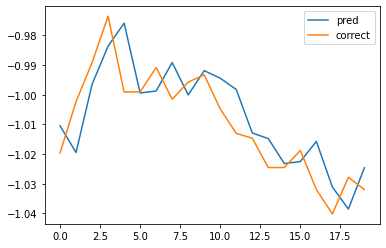

In [45]:
plt.plot(pred[0:20])
plt.plot(correct[:20])
plt.legend(['pred', 'correct'])

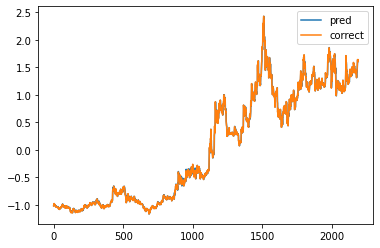

In [46]:
plt.plot(pred[:4000])
plt.plot(correct[:4000])
plt.legend(['pred', 'correct'])